In [26]:
!pip install livelossplot --quiet

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from livelossplot import PlotLosses

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [6]:
train_set = np.load('drive/MyDrive/EDVAM/train.npy')
train_label = np.load('drive/MyDrive/EDVAM/train_label.npy')

test_set = np.load('drive/MyDrive/EDVAM/test.npy')
test_label = np.load('drive/MyDrive/EDVAM/test_label.npy')

In [7]:
train_set.shape

(190830, 300, 40)

In [8]:
time_samples = [i for i in range(0, 150, 6)] + [i for i in range(150, 240, 5)] + \
               [i for i in range(240, 290, 2)] + [i for i in range(290, 300)]
features = [i for i in range(10)]

In [11]:
ds_train = torch.utils.data.TensorDataset(torch.Tensor(train_set[:, time_samples, :][:, :, features]),\
                                          torch.Tensor(train_label).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)

ds_test = torch.utils.data.TensorDataset(torch.Tensor(test_set[:, time_samples, :][:, :, features]),\
                                         torch.Tensor(test_label).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=128, shuffle=True)

In [12]:
datasets = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_set), 'val': len(test_set)}

In [28]:
class lstmNet(nn.Module):
  def __init__(self, input_size=len(features)):
    super().__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=20, num_layers=3, batch_first=True)
    self.fc1 = nn.Linear(20, 12)
        
  def forward(self, x):
    x_, (h_n, c_n) = self.lstm(x)
    x_ = (x_[:, -1, :])
    x_ = self.fc1(x_)
    return x_

class gruNet(nn.Module):
  def __init__(self, input_size=len(features)):
    super().__init__()
    self.gru = nn.GRU(input_size=input_size, hidden_size=20, num_layers=3, batch_first=True)
    self.fc1 = nn.Linear(20, 12)
        
  def forward(self, x):
    x_, h_n = self.gru(x)
    x_ = (x_[:, -1, :])
    x_ = self.fc1(x_)
    return x_
  
def convNet(nn.Module):
  def __init__(self, input_shape=(len(time_samples), len(features))):
    super().__init__()
  
  def forward(self, x):
    return x


In [40]:
print(ds_train.tensors[0].size()[1])

78


In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
  best_model_wts = model.state_dict()
  best_acc = 0.0
  best_epoch = 0

  liveloss = PlotLosses()
  model = model.to(device)

  for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'val']:
      if phase == 'train':
        scheduler.step()
        model.train(True)
      else:
        model.train(False)
    
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in datasets[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.float() / dataset_sizes[phase]

      prefix = 'val_' if phase == 'val' else ''

      logs[prefix + 'log loss'] = epoch_loss.item()
      logs[prefix + 'accuracy'] = epoch_acc.item()

      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_epoch = epoch
          best_model_wts = model.state_dict()
    
    liveloss.update(logs)
    liveloss.send()
  
  return best_model_wts

In [24]:
model = lstmNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

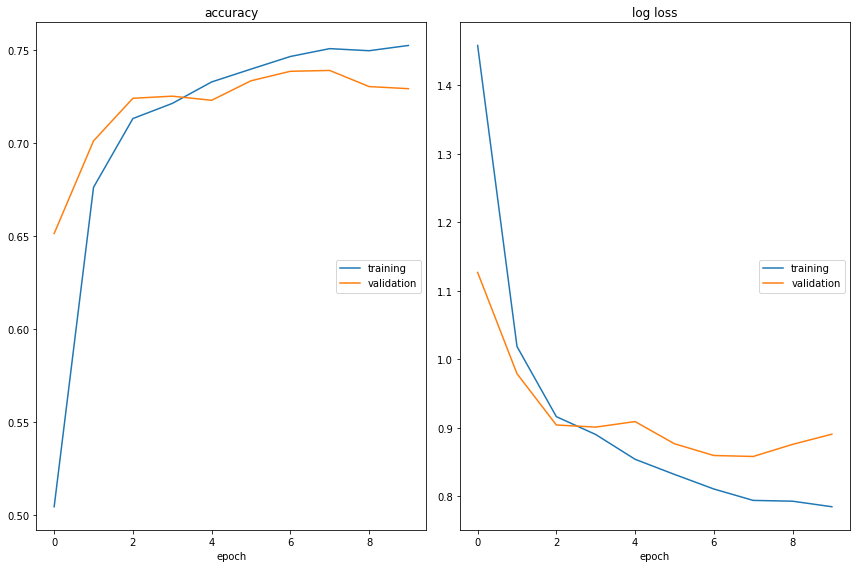

accuracy
	training         	 (min:    0.505, max:    0.752, cur:    0.752)
	validation       	 (min:    0.651, max:    0.739, cur:    0.729)
log loss
	training         	 (min:    0.785, max:    1.458, cur:    0.785)
	validation       	 (min:    0.858, max:    1.127, cur:    0.891)


In [25]:
best_model = train_model(model, criterion, optimizer, scheduler, 10)